In [2]:
import numpy as np

In [3]:
FEATURE_DIR = '/oasis/projects/nsf/csd395/jiaxuzhu/vgg16_features'

In [4]:
labels = ['Pn', '12N', 'Gr', "7N", '7n', "5N", 'VLL', 'LVe', 'SuVe']

In [6]:
features = {}

for label in labels:
    features[label] = np.load(FEATURE_DIR + '/' + label + '_features.npy')

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

In [155]:
for label in labels:
    b = np.ascontiguousarray(features[label]).view(np.dtype((np.void, features[label].dtype.itemsize * features[label].shape[1])))
    _, idx = np.unique(b, return_index=True)
    features[label] = features[label][idx]

In [159]:
for label, f in features.iteritems():
    print label, f.shape[0]

Gr 36
7N 646
SuVe 84
12N 161
LVe 424
5N 312
7n 121
Pn 1940
VLL 247


In [160]:
pooled = {}
for l in labels:
    print l
    x = np.sum(features[l]**3, axis=0)
    pooled[l] = np.sign(x) * np.power(np.abs(x), 1./3)

Pn
12N
Gr
7N
7n
5N
VLL
LVe
SuVe


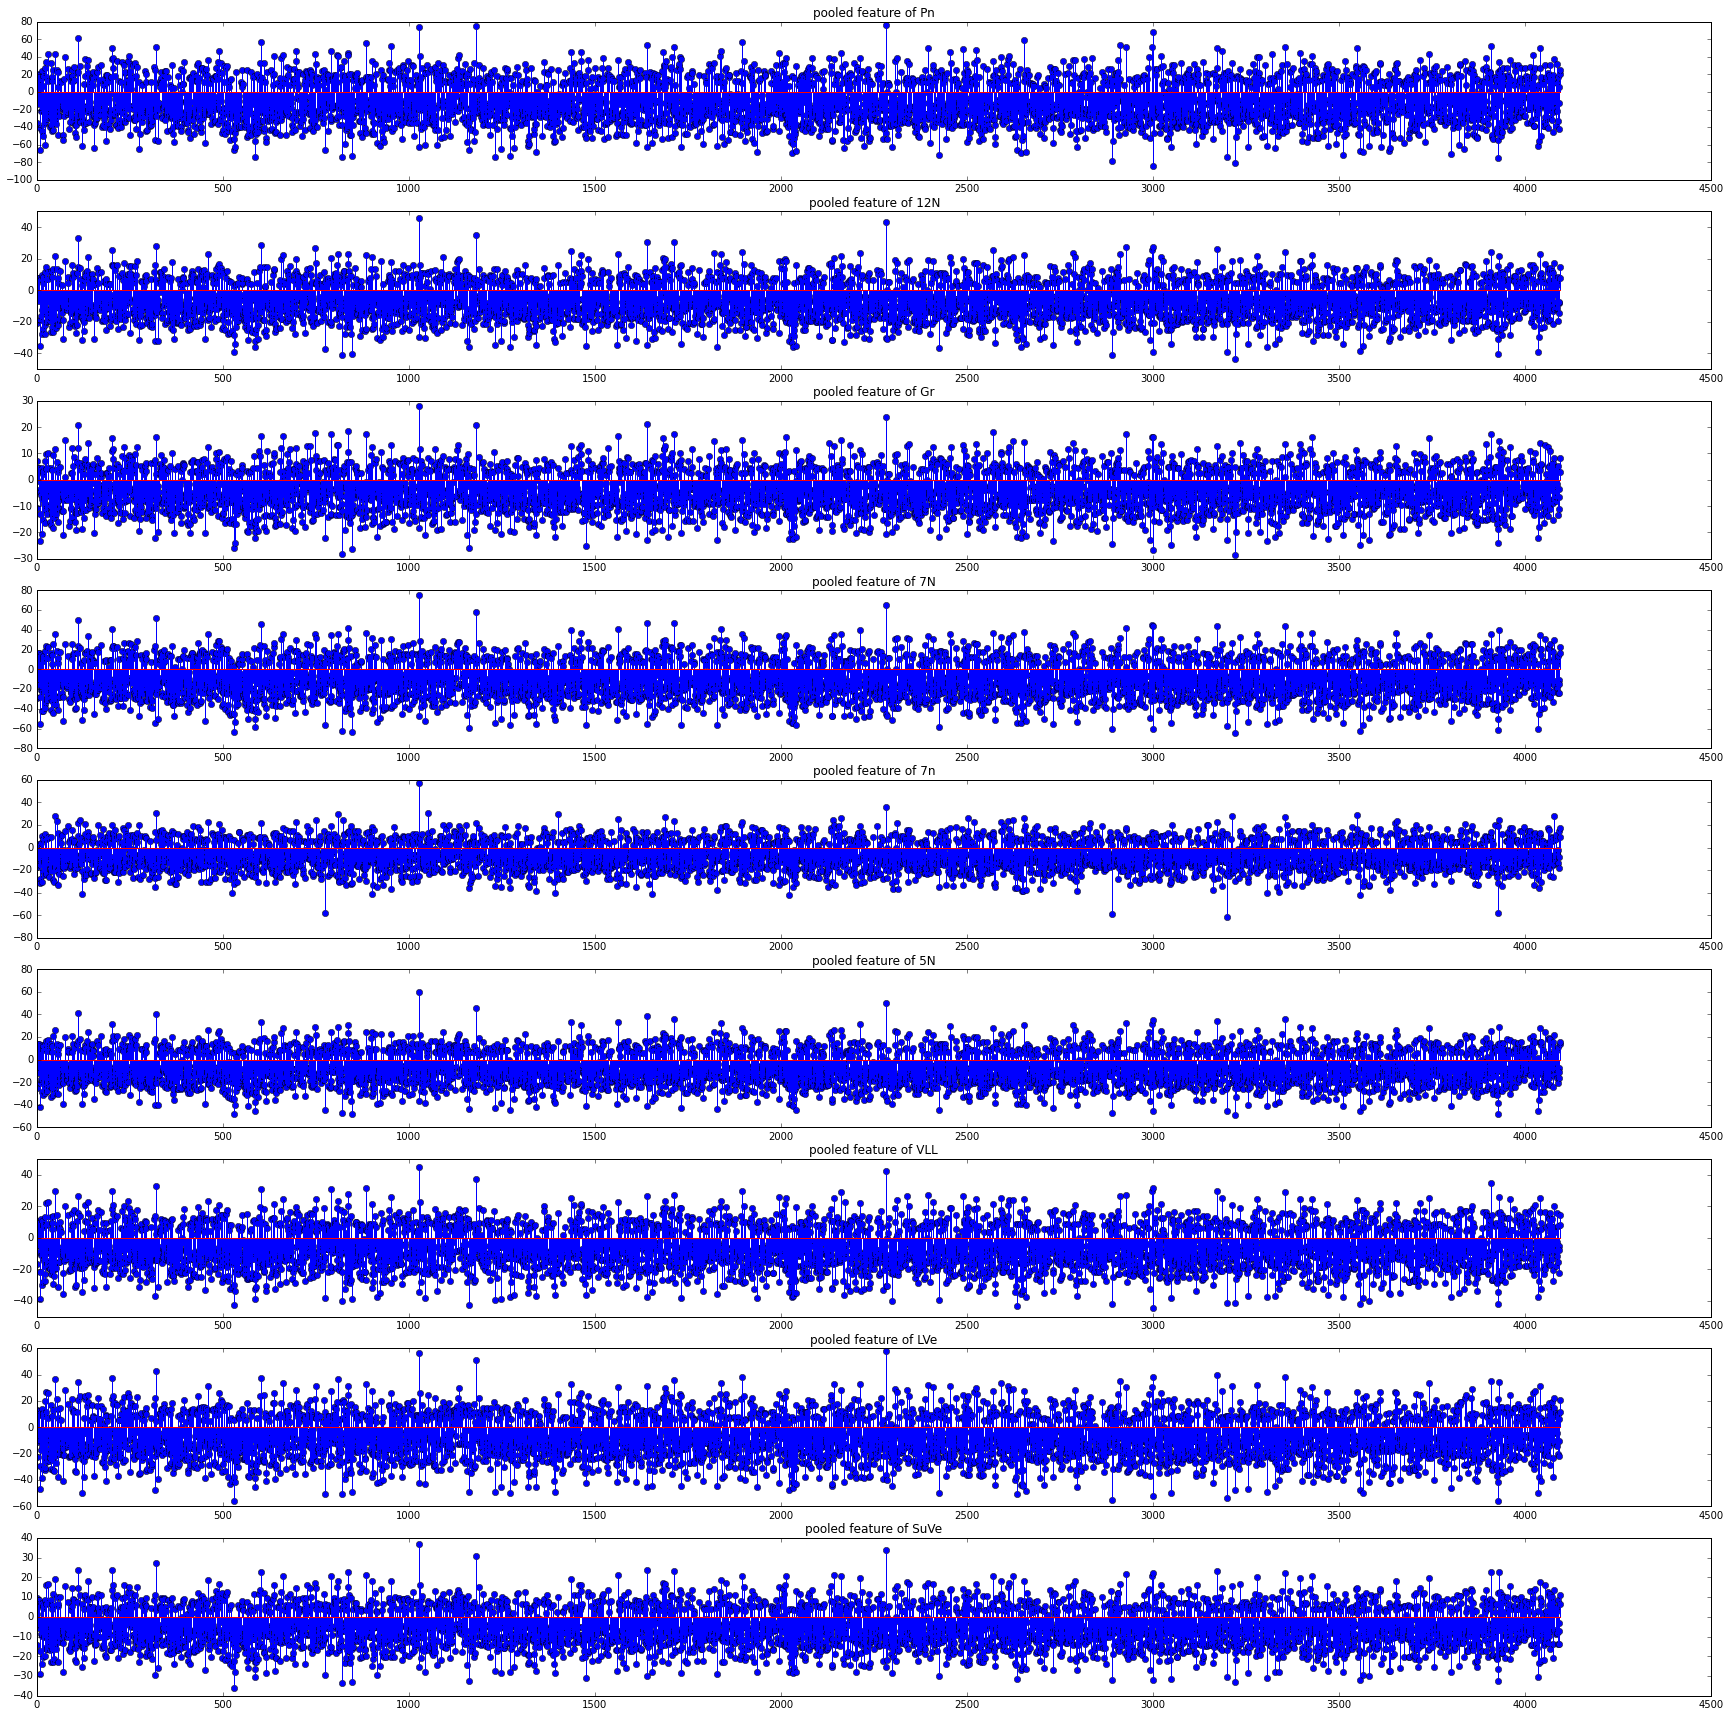

In [161]:
fig, axes = plt.subplots(len(labels), 1, figsize=(30,30))

for i, label in enumerate(labels):
    axes[i].stem(pooled[label])
    axes[i].set_title('pooled feature of %s' % label)

In [246]:
label1 = '12N'
label2 = 'Gr'

# label1 = 'LVe'
# label2 = 'SuVe'

In [247]:
x1 = pooled[label1]
x2 = pooled[label2]

# plt.figure(figsize=(30,3));
# plt.stem(np.abs(x1 - x2));
# plt.title('value difference between features of %s and %s' % (label1, label2));

In [248]:
most_different_feature_indices = np.argsort(np.abs(x1 - x2))[-100:]

In [249]:
n = min(features[label1].shape[0]/2, features[label2].shape[0]/2)
print n, 'training instances each class'
x1_reduced = features[label1][:n, most_different_feature_indices]
x2_reduced = features[label2][:n, most_different_feature_indices]

18 training instances each class


In [250]:
from sklearn.svm import SVC

In [251]:
clf = SVC(probability=True, kernel='linear')
# clf = SVC(probability=True, kernel='poly', degree=3)
# clf = SVC(probability=True, kernel='rbf')

In [252]:
X = np.r_[x1_reduced, x2_reduced]
Y = np.r_[np.ones(x1_reduced.shape[0]), -np.ones(x2_reduced.shape[0])]
clf.fit(X, Y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0, degree=3, gamma=0.0,
  kernel='linear', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [253]:
clf.n_support_

array([8, 8], dtype=int32)

In [254]:
x1_reduced_test = features[label1][n:, most_different_feature_indices]
x2_reduced_test = features[label2][n:, most_different_feature_indices]
X_test = np.r_[x1_reduced_test, x2_reduced_test]
Y_test = np.r_[np.ones(x1_reduced_test.shape[0]), -np.ones(x2_reduced_test.shape[0])]

# wrong instances
wrong_instances1 = np.where((clf.predict(X_test) == 1) & (Y_test == -1))[0]
err_rate1 = len(wrong_instances1)/float(x1_reduced_test.shape[0])
print '%s mistaken as %s' % (label1, label2), wrong_instances1, ', error rate = %.3f' % err_rate1

wrong_instances2 = np.where((clf.predict(X_test) == -1) & (Y_test == 1))[0]
err_rate2 = len(wrong_instances2)/float(x2_reduced_test.shape[0])
print '%s mistaken as %s' % (label2, label1), wrong_instances2, ', error rate = %.3f' % err_rate2

12N mistaken as Gr [] , error rate = 0.000
Gr mistaken as 12N [ 29  56  65 120] , error rate = 0.222


In [256]:
print clf.intercept_
print clf.coef_
# only for linear kernel
margin = 1 / np.sqrt(np.sum(clf.coef_ ** 2))
print margin

[-1.30573421]
[[-0.09256041  0.10749623  0.0631898   0.10586706  0.05450807 -0.02870455
   0.14217458  0.04403355  0.06025204 -0.03394911 -0.0448169   0.0779963
   0.01156144  0.01765296  0.00384384 -0.05979637  0.06359693  0.08740461
   0.11460693  0.04326081 -0.06678396 -0.08595721  0.05718995  0.11877289
  -0.00113296  0.01904711  0.05527815 -0.00849542  0.07512867 -0.09414339
  -0.02616484  0.05881251  0.09089296 -0.05613098 -0.00843055 -0.02510075
  -0.01562536  0.02952321 -0.07404893  0.08978544  0.01333888 -0.02411592
   0.07663641 -0.00608302  0.04914924 -0.00094812 -0.09665096  0.01503879
   0.12771783  0.03202687 -0.01540539  0.00024114  0.09933464 -0.01365379
   0.03245864 -0.01138455 -0.0340504  -0.01380874 -0.02102573 -0.02703903
  -0.13912288 -0.08850803  0.1485005   0.02561198 -0.00331969  0.0111005
   0.05447935  0.00232404 -0.08991226  0.00462227 -0.01236272 -0.00754325
  -0.02114574 -0.10012513 -0.00335254 -0.00893639 -0.0068889   0.01614331
   0.09078205 -0.03389439 

In [258]:
np.save('%s_%s_linear_svm_coef.npy' % (label1, label2), clf.coef_)
np.save('%s_%s_linear_svm_intercept.npy' % (label1, label2), clf.intercept_)
np.save('%s_%s_linear_svm_selectedFeatureIndices.npy' % (label1, label2), most_different_feature_indices)

In [243]:
probs = clf.predict_proba(X_test)

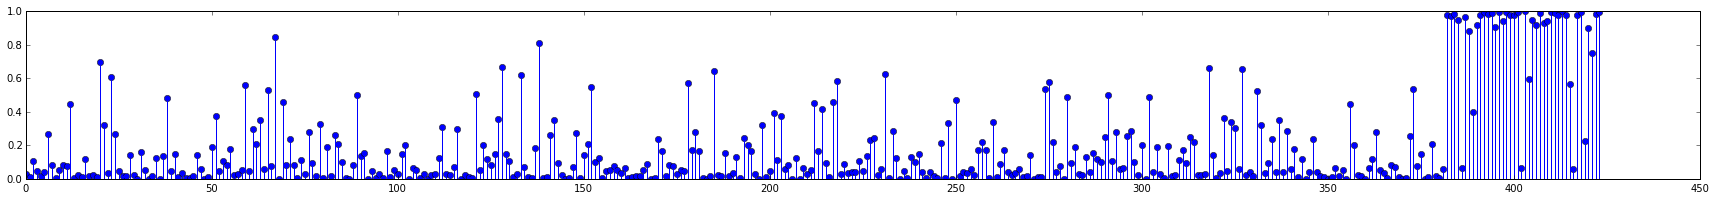

In [244]:
plt.figure(figsize=(30,3));
plt.stem(probs[:,0]);
plt.ylim([0,1]);

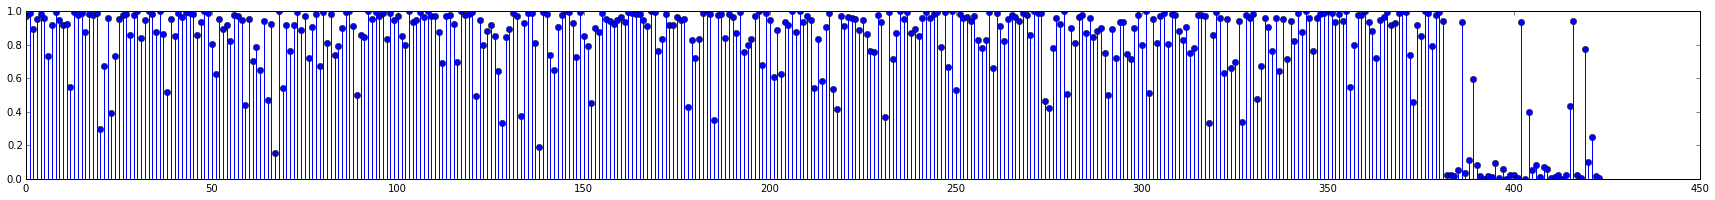

In [245]:
plt.figure(figsize=(30,3));
plt.stem(probs[:, 1]);
plt.ylim([0,1]);

In [12]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA(n_components=10, copy=True, whiten=False)
pca.fit(features['12N'])